In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

In [12]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'medicalcosts'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
medical_df = pd.read_sql_query('select * from medicalcosts',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

# OLS REGRESSION:

In [13]:
medical_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.900
1,18,male,33.770,1,no,southeast,1725.550
2,28,male,33.000,3,no,southeast,4449.460
3,33,male,22.705,0,no,northwest,21984.500
4,32,male,28.880,0,no,northwest,3866.860


In [14]:
total_missing = medical_df.isnull().sum().sort_values(ascending=False)
percent_missing = (medical_df.isnull().sum()/medical_df.isnull().count()).sort_values(ascending=False)

missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total','Percent'])
missing_data

,Total,Percent
charges,0,0.000
region,0,0.000
smoker,0,0.000
children,0,0.000
bmi,0,0.000
sex,0,0.000
age,0,0.000


In [15]:
medical_df['is_male'] = pd.get_dummies(medical_df.sex, drop_first=True)
medical_df['is_female'] = pd.get_dummies(medical_df.sex, drop_first=True)

In [17]:
medical_df['is_smoker'] = pd.get_dummies(medical_df.smoker, drop_first=True)

In [18]:
medical_df.head()

,age,sex,bmi,children,smoker,region,charges,is_male,is_female,is_smoker
0,19,female,27.900,0,yes,southwest,16884.900,0,0,1
1,18,male,33.770,1,no,southeast,1725.550,1,1,0
2,28,male,33.000,3,no,southeast,4449.460,1,1,0
3,33,male,22.705,0,no,northwest,21984.500,1,1,0
4,32,male,28.880,0,no,northwest,3866.860,1,1,0


In [22]:
# Y is the target variable
Y = medical_df['charges']

medical_df['bmi_is_smoker'] = medical_df.bmi * medical_df.is_smoker

#independent  variables 
X = medical_df[['is_male','is_smoker','bmi','age','bmi_is_smoker']]

# adding a constant to the model
X = sm.add_constant(X)

# fit an OLS model
results = sm.OLS(Y, X).fit()

print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     1365.
Date:                Wed, 19 Feb 2020   Prob (F-statistic):               0.00
Time:                        16:01:35   Log-Likelihood:                -13265.
No. Observations:                1338   AIC:                         2.654e+04
Df Residuals:                    1332   BIC:                         2.657e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2071.0750    840.644     -2.464

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)


In [24]:
print('the number of obervations in the training set is {}'.format(X_train.shape[0]))
print('the number of observations in the test set it {}'.format(X_test.shape[0]))

the number of obervations in the training set is 1070
the number of observations in the test set it 268


In [25]:
X_train = sm.add_constant(X_train)

In [26]:
results = sm.OLS(y_train, X_train).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     1052.
Date:                Wed, 19 Feb 2020   Prob (F-statistic):               0.00
Time:                        16:08:45   Log-Likelihood:                -10631.
No. Observations:                1070   AIC:                         2.127e+04
Df Residuals:                    1064   BIC:                         2.130e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2239.3091    964.274     -2.322

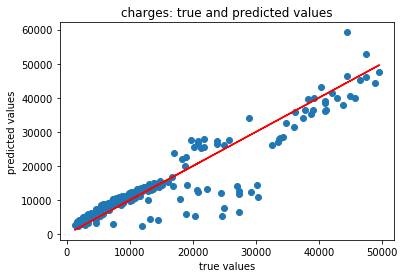

mean absolute error of the predictions is: 2749.4722864791775
mean squared error of the predictions is: 19957476.990353025
root mean squared error of the prediction is: 4467.379208255443
mean absolute percentage error of the prediction is: 29.237052069764484


In [27]:
X_test = sm.add_constant(X_test)

y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color='red')
plt.xlabel('true values')
plt.ylabel('predicted values')
plt.title('charges: true and predicted values')
plt.show()

print('mean absolute error of the predictions is: {}'.format(mean_absolute_error(y_test, y_preds)))
print('mean squared error of the predictions is: {}'.format(mse(y_test, y_preds)))
print('root mean squared error of the prediction is: {}'.format(rmse(y_test, y_preds)))
print('mean absolute percentage error of the prediction is: {}'.format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))


# KNN Regression:

In [72]:
medical_df.head()

,age,sex,bmi,children,smoker,region,charges,is_male,is_female,is_smoker,bmi_is_smoker
0,19,female,27.900,0,yes,southwest,16884.900,0,0,1,27.900
1,18,male,33.770,1,no,southeast,1725.550,1,1,0,0.000
2,28,male,33.000,3,no,southeast,4449.460,1,1,0,0.000
3,33,male,22.705,0,no,northwest,21984.500,1,1,0,0.000
4,32,male,28.880,0,no,northwest,3866.860,1,1,0,0.000


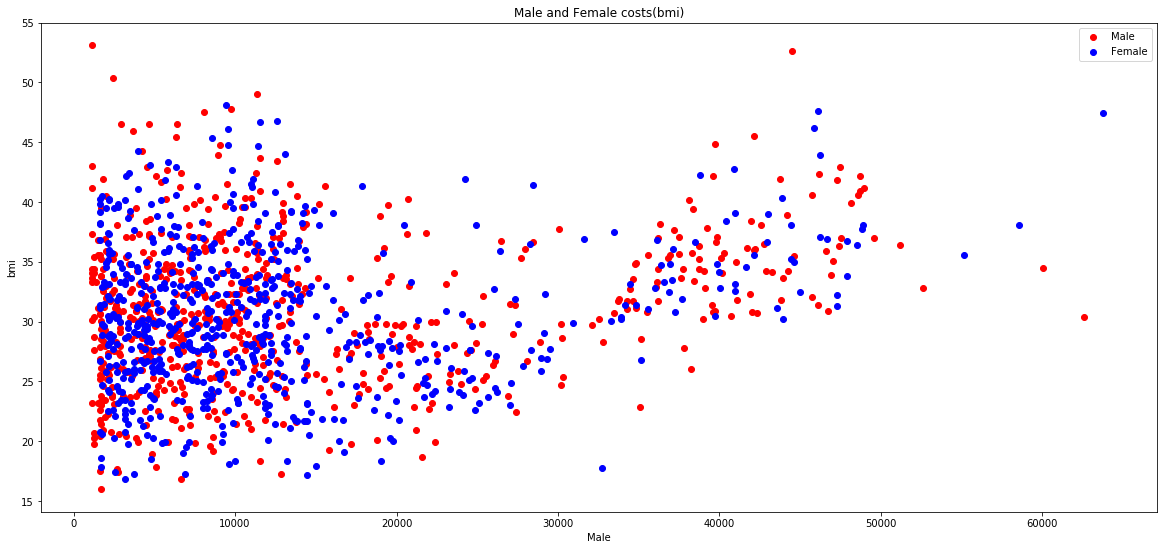

In [104]:
plt.figure(figsize=(20,9))

plt.scatter(medical_df[medical_df['is_male'] == 1].charges,medical_df[medical_df['is_male'] == 1].bmi,color='red' )

plt.scatter(medical_df[medical_df['is_male'] == 0].charges,medical_df[medical_df['is_male'] == 0].bmi,color='blue' )

plt.legend(['Male','Female'])
plt.title('Male and Female costs(bmi)')
plt.xlabel('Male')
plt.ylabel('bmi')
plt.show()

In [105]:
from sklearn.neighbors import KNeighborsClassifier
neighbors = KNeighborsClassifier(n_neighbors=3)
X = medical_df[['charges','bmi']]
Y = medical_df.is_male
neighbors.fit(X, Y)

print(neighbors.predict([[10000,40]]))
print(neighbors.predict_proba([[1000,40]]))


[0]
[[0. 1.]]


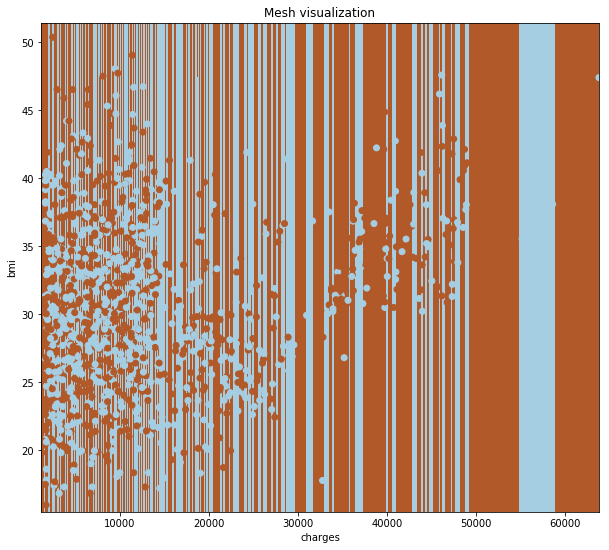

In [112]:
# Our data. Converting from data frames to arrays for the mesh.
plt.figure(figsize=(10,9))

X = np.array(X)
Y = np.array(Y)

# Mesh size.
h = 4.0

# Plot the decision boundary. We assign a color to each point in the mesh.
x_min = X[:, 0].min() - .5
x_max = X[:, 0].max() + .5
y_min = X[:, 1].min() - .5
y_max = X[:, 1].max() + .5
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h),
    np.arange(y_min, y_max, h)
)
Z = neighbors.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot.
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(6, 4))
plt.set_cmap(plt.cm.Paired)
plt.pcolormesh(xx, yy, Z)

# Add the training points to the plot.
plt.scatter(X[:, 0], X[:, 1], c=Y)
plt.xlabel('charges')
plt.ylabel('bmi')
plt.title('Mesh visualization')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.show()

I like using the OLS Regression. Compared to the KNN, the OLS Regression is a lot easier to understand.The mean absolute error of the predictions is: 2749 The mean squared error of the predictions is: 19957476 The root mean squared error of the prediction is: 4467 The
mean absolute percentage error of the prediction is: 29 The mesh visualization to me does not look good visually. 